In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
import torch
import torch.nn as nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
'''这段代码是借鉴网上的，以前没有这样处理过数据'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = datasets.CIFAR10(root="../input/cifar10-python", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = datasets.CIFAR10(root="../input/cifar10-python", train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [4]:
def conv3x3(inchannel, outchannel, stride=1,padding=1):
    return nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride,
                     padding=padding,bias=False)

def conv1x1(inchannel, outchannel, stride=1):
    return nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False)

In [5]:
class Bottleneck(nn.Module):
    expansion=4
    def __init__(self, inchannel, outchannel, stride=1, down_sample=None,  dilation=1, norm_layer=nn.BatchNorm2d):  
        #groups用于控制卷积操作中的分组数量,dilation用于控制卷积核的扩张率(在此处表示padding),downsample是为了对应残差块输入通道和输出通道相加匹配
        super(Bottleneck,self).__init__()
        midchannel=outchannel//4        
        self.conv1 = conv1x1(inchannel, midchannel, stride=stride)
        self.bn1 = norm_layer(midchannel)
        self.conv2 = conv3x3(midchannel, midchannel)
        self.bn2 = norm_layer(midchannel)
        self.conv3 = conv1x1(midchannel, outchannel)
        self.bn3 = norm_layer(outchannel)
        self.relu = nn.ReLU(inplace=True)
        self.down_sample=down_sample
        self.stride = 2 if down_sample else 1
        if down_sample is not None:
            self.down_sample = down_sample
        elif stride != 1 or inchannel != outchannel:
            self.down_sample = nn.Sequential(
                conv1x1(inchannel, outchannel, stride),
                norm_layer(outchannel),
            )
        else:
            self.down_sample = None
        self.stride = stride
        
    def forward(self, x):
        #identity = x
        #print(x.shape)  #torch.Size([32, 64, 55, 55])
        out = self.conv1(x)
        #print(out.shape)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        #residual思想代码
        if self.down_sample is not None:
            identity = self.down_sample(x)
        else:
            identity = x

        out += identity
        out = self.relu(out)

        return out

In [6]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.pre = nn.Sequential(*[
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2,padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ])
        self.stages = nn.Sequential(*[
            self._make_stage(64, 256, down_sample=False, num_blocks=3),
            self._make_stage(256, 512, down_sample=True, num_blocks=4),
            self._make_stage(512, 1024, down_sample=True, num_blocks=6),
            self._make_stage(1024, 2048, down_sample=True, num_blocks=3),
        ])
        self.final = nn.Sequential(*[
            nn.AvgPool2d(kernel_size=7, stride=1, padding=0),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(2048, num_classes)
        ])

    def _make_stage(self, in_channels, out_channels, down_sample, num_blocks):
        downsample = None
        stride = 1
        if down_sample:
            stride = 2
            downsample = nn.Sequential(
                conv1x1(in_channels, out_channels, stride),
                nn.BatchNorm2d(out_channels),
            )
        layers = [Bottleneck(in_channels, out_channels, stride=stride, down_sample=downsample)]
        for _ in range(1, num_blocks):
            layers.append(Bottleneck(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.final(self.stages(self.pre(x)))

In [7]:
net = ResNet50(num_classes=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01)
loss_resnet = nn.CrossEntropyLoss()

[1, 200] loss: 2.449
[1, 400] loss: 1.927
[1, 600] loss: 1.747
[1, 800] loss: 1.646
[1, 1000] loss: 1.544
[1, 1200] loss: 1.503
[1, 1400] loss: 1.445
[2, 200] loss: 1.332
[2, 400] loss: 1.299
[2, 600] loss: 1.251
[2, 800] loss: 1.170
[2, 1000] loss: 1.137
[2, 1200] loss: 1.136
[2, 1400] loss: 1.089
[3, 200] loss: 1.015
[3, 400] loss: 0.992
[3, 600] loss: 0.939
[3, 800] loss: 0.919
[3, 1000] loss: 0.931
[3, 1200] loss: 0.876
[3, 1400] loss: 0.839
[4, 200] loss: 0.751
[4, 400] loss: 0.764
[4, 600] loss: 0.754
[4, 800] loss: 0.730
[4, 1000] loss: 0.721
[4, 1200] loss: 0.693
[4, 1400] loss: 0.653
[5, 200] loss: 0.601
[5, 400] loss: 0.597
[5, 600] loss: 0.586
[5, 800] loss: 0.583
[5, 1000] loss: 0.611
[5, 1200] loss: 0.567
[5, 1400] loss: 0.579
[6, 200] loss: 0.476
[6, 400] loss: 0.509
[6, 600] loss: 0.484
[6, 800] loss: 0.503
[6, 1000] loss: 0.517
[6, 1200] loss: 0.487
[6, 1400] loss: 0.472
[7, 200] loss: 0.384
[7, 400] loss: 0.415
[7, 600] loss: 0.439
[7, 800] loss: 0.409
[7, 1000] loss: 

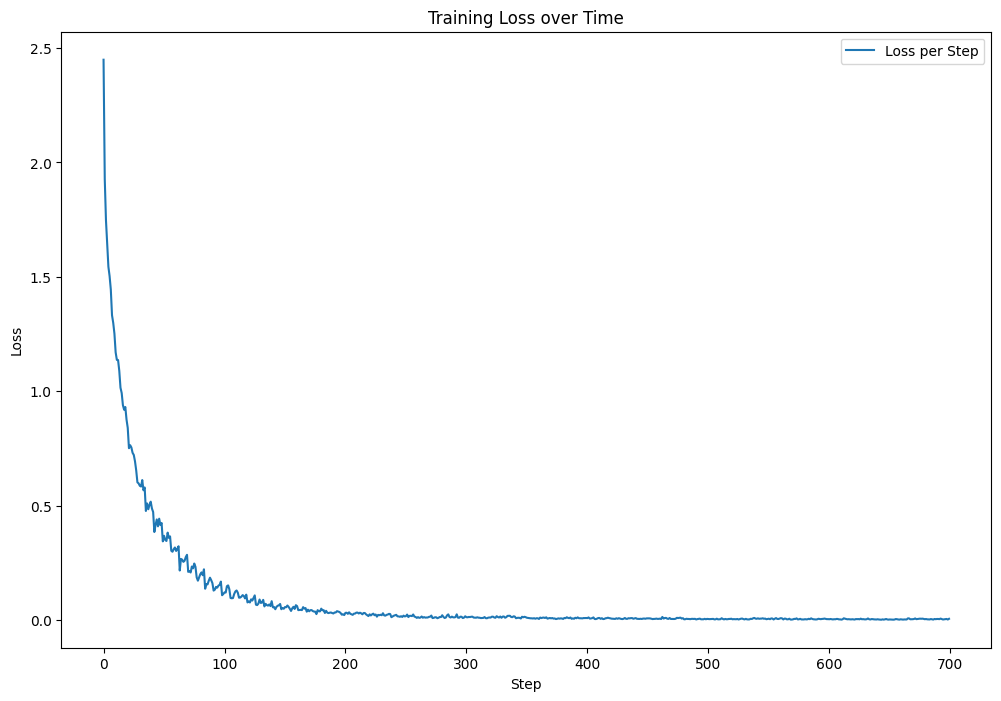

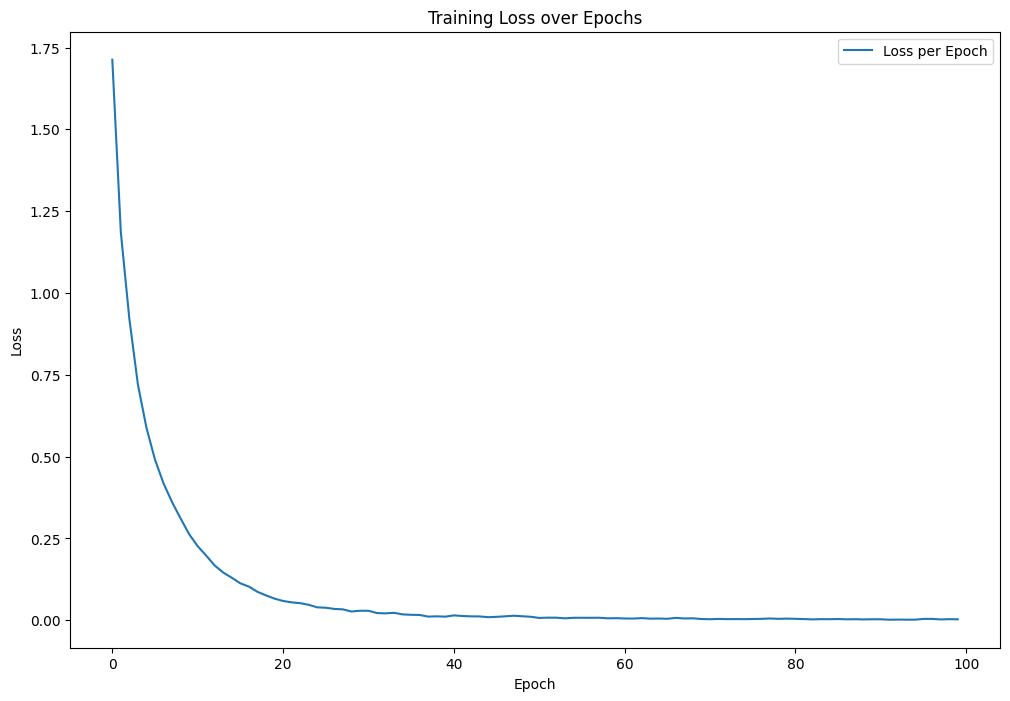

In [8]:
losses = []
epoch_losses = []  

for epoch in range(100):  
    running_loss = 0.0
    epoch_loss = 0.0  
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_resnet(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()  # 将每个batch的损失添加到epoch_loss中
        if i % 200 == 199:  
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}")
            losses.append(running_loss / 200)
            running_loss = 0.0

    epoch_losses.append(epoch_loss / len(trainloader))  # 在每个epoch结束时计算平均损失并添加到epoch_losses列表中
            
# 绘制每个step的损失图像
plt.figure(figsize=(12, 8))
plt.plot(losses, label='Loss per Step')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.savefig('/kaggle/working/loss_plot.png')
plt.show()

# 绘制每个epoch的损失图像
plt.figure(figsize=(12, 8))
plt.plot(epoch_losses, label='Loss per Epoch')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.savefig('/kaggle/working/loss_epoch_plot.png')
plt.show()

In [9]:
num_classes = 10
confusion = np.zeros((num_classes, num_classes), dtype=int)
correct = 0
total = 0

all_labels = []
all_predicted = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        # 更新混淆矩阵
        confusion += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=np.arange(num_classes))

accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='macro')
recall = recall_score(all_labels, all_predicted, average='macro')
f1 = f1_score(all_labels, all_predicted, average='macro')

print(f"Accuracy on test set: {100 * accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Accuracy on test set: 87.48%
Precision: 0.87
Recall: 0.87
F1 Score: 0.87
Confusion Matrix:
[[889   5  24  12   5   3   6   9  31  16]
 [  8 936   2   1   1   1   3   4   9  35]
 [ 24   0 830  27  37  27  40  10   5   0]
 [ 15   5  39 759  22  85  36  21  16   2]
 [  7   3  32  31 857  17  21  28   4   0]
 [  7   0  22  99  13 819   9  23   5   3]
 [  8   2  22  39  12  11 902   1   2   1]
 [  6   1  17  18  18  21   2 912   2   3]
 [ 29   9   3   5   1   2   3   2 930  16]
 [ 13  33   2   7   2   0   5   5  19 914]]
